### DEPTH exposure time calculation

Based on D.Kirkby notebook

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import fitsio
import astropy.table
import scipy.ndimage
from astropy.table import Table

In [2]:
ROOT = Path('/global/cfs/cdirs/desi/spectro/redux/andes/')
assert ROOT.exists()

In [3]:
wmin, wmax, wdelta = 3600, 9824, 0.8
fullwave = np.round(np.arange(wmin, wmax + wdelta, wdelta), 1)
cslice = {'b': slice(0, 2751), 'r': slice(2700, 5026), 'z': slice(4900, 7781)}

In [4]:
class Spectrum(object):
    def __init__(self, stype, flux=None, ivar=None, mask=None):
        assert stype is 'full' or stype in cslice, 'invalid stype'
        self.stype = stype
        self.wave = fullwave[cslice[stype]] if stype in cslice else fullwave
        if flux is None and ivar is None:
            self._flux = np.zeros(len(self.wave))
            self.ivar = np.zeros(len(self.wave))
        elif flux is not None and ivar is not None:
            self._flux = np.asarray(flux)
            self.ivar = np.asarray(ivar)
            assert self.ivar.shape == self._flux.shape, 'flux and ivar have different shapes.'
        else:
            raise ValueError('flux and ivar must both be specified.')
        if mask is None:
            self.mask = np.zeros_like(self._flux, bool)
        else:
            self.mask = np.asarray(mask)
            assert self.mask.shape == self._flux.shape, 'flux and mask have different shapes.'
    def copy(self):
        return Spectrum(self.stype, self.flux.copy(), self.ivar.copy(), self.mask.copy())
    def __itruediv__(self, factor):
        np.divide(self.flux, factor, out=self._flux, where=factor != 0)
        self.ivar *= factor ** 2
        return self
    def __truediv__(self, factor):
        result = self.copy()
        result /= factor
        return result
    @property
    def flux(self):
        return self._flux

<>:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-4-95b1cc66c73a>:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
  assert stype is 'full' or stype in cslice, 'invalid stype'


In [5]:
class CoAdd(Spectrum):
    def __init__(self, stype):
        super(CoAdd, self).__init__(stype)
        self._weighted_flux_sum = np.zeros(len(self.wave))
        self._finalized = False
    def __iadd__(self, other):
        if other.stype == self.stype:
            self_slice = slice(None, None)
        elif self.stype == 'full':
            self_slice = cslice[other.stype]
        else:
            raise ValueError(f'Cannot add "{other.stype}" to "{self.stype}".')
        self._weighted_flux_sum[self_slice] += other.ivar * other.flux
        self.ivar[self_slice] += other.ivar
        self._finalized = False
        return self
    @property
    def flux(self):
        if not self._finalized:
            np.divide(self._weighted_flux_sum, self.ivar, out=self._flux, where=self.ivar > 0)
            self._finalized = True
        return self._flux

In [6]:
def exposures_of_tile(tileid, night):
    paths = (ROOT / 'tiles' / str(tileid) / str(night)).glob(f'cframe-[brz][0-9]-????????.fits')
    expids = set()
    for path in sorted(paths):
        expids.add(int(path.name[-13:-5]))
    return sorted(expids)

Read DESIMODEL throughputs for each spectrograph from a local copy obtained using:
```
svn co https://desi.lbl.gov/svn/code/desimodel/tags/0.13.0/data/throughput thru13
```

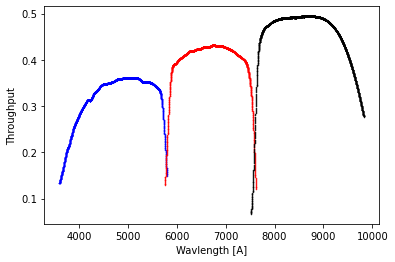

In [7]:
def load_spec_thru(path='thru13'):
    thru = {}
    for camera, color in zip('brz', 'brk'):
        data = fitsio.read(f'{path}/thru-{camera}.fits', 'THROUGHPUT')
        thru[camera] = np.interp(fullwave[cslice[camera]], data['wavelength'], data['throughput'])
        plt.plot(fullwave[cslice[camera]], thru[camera], '.', c=color, ms=1)
    plt.xlabel('Wavlength [A]')
    plt.ylabel('Throughput')
    return thru

spec_thru = load_spec_thru()

## GFA Analysis

Read offline GFA measurements of transparency and fiber fraction from the FITS file attached to the [SV0 wiki page](https://desi.lbl.gov/trac/wiki/TargetSelectionWG/SV0):

In [8]:
gfa_results = fitsio.read('desi_sv0_exposures_gfa.fits', ext=1)

In [9]:
gfa_results["tileid"]

array([67230, 67230, 67230, 68000, 68000, 66014, 66014, 66014, 66014,
       66000, 66000, 66000, 66000, 65008, 65008, 65008, 65008, 66019,
       66019, 66019, 66019, 67230, 67230, 67230, 67230, 67230, 67230,
       68001, 68001, 68001, 68002, 68002, 68002, 67142, 67142, 67142,
       67142, 67142, 66003, 66003, 66003])

In [10]:
gfa_results.dtype

dtype([('expid', '>i8'), ('night', '>i8'), ('tileid', '>i8'), ('exptime', '>f4'), ('mjdobs', '>f4'), ('tilera', '>f4'), ('tiledec', '>f4'), ('airmass_min', '>f4'), ('airmass_med', '>f4'), ('airmass_max', '>f4'), ('moon_sep_deg_min', '>f4'), ('moon_sep_deg_med', '>f4'), ('moon_sep_deg_max', '>f4'), ('transparency_min', '>f4'), ('transparency_med', '>f4'), ('transparency_max', '>f4'), ('fwhm_asec_min', '>f4'), ('fwhm_asec_med', '>f4'), ('fwhm_asec_max', '>f4'), ('sky_mag_ab_min', '>f4'), ('sky_mag_ab_med', '>f4'), ('sky_mag_ab_max', '>f4'), ('fiber_fracflux_min', '>f4'), ('fiber_fracflux_med', '>f4'), ('fiber_fracflux_max', '>f4'), ('ngfa', '>i8'), ('ebv', '>f4')])

## Sky Background

Estimate the average sky for a single exposure in phot/sec detected in each camera and incident on M1:

In [11]:
_sky_cache = {}

In [12]:
def get_sky(night, expid, specs=range(10), use_cache=True, fill_cache=True):
    """Estimate the sky spectrum for one exposure in units of phot/sec per wavelength bin.
    
    Returns a tuple (flux_inc, ivar_inc, flux_det, ivar_det) where "det" is detected phot/sec
    in each camera with flat-field corrections applied, and "inc" corrects for the average
    spectrograph throughput in each camera, then coadds over cameras.
    """
    night = str(night)
    expid = str(expid).zfill(8)
    if use_cache and (night, expid) in _sky_cache:
        return _sky_cache[(night, expid)]
    incident = CoAdd('full')
    detected = {}
    # Loop over cameras.
    for camera in 'brz':
        detected[camera] = CoAdd(camera)
        # Loop over spectrographs.
        for spec in specs:
            # Read the flat-fielded (constant) sky model in this spectrograph.
            skypath = ROOT / 'exposures' / night / expid / f'sky-{camera}{spec}-{expid}.fits'
            if not skypath.exists():
                print(f'Skipping non-existent {camera}{spec}.')
                continue
            with fitsio.FITS(str(skypath)) as hdus:
                exptime = hdus[0].read_header()['EXPTIME']
                flux = hdus['SKY'].read()
                ivar = hdus['IVAR'].read()
                mask = hdus['MASK'].read()
                # Verify that we have the expected wavelengths.
                assert np.allclose(detected[camera].wave, hdus['WAVELENGTH'].read())
                # Verify that ivar is purely statistical.
                assert np.array_equal(ivar, hdus['STATIVAR'].read())
                # Verify that the model has no masked pixels.
                assert np.all((mask == 0) & (ivar > 0))
                # Verify that the sky model is constant.
                assert np.array_equal(np.max(ivar, axis=0), np.min(ivar, axis=0))
                ##assert np.allclose(np.max(flux, axis=0), np.min(flux, axis=0))
                # There are actually small variations in flux!
                # TODO: figure out where these variations come from.
                # For now, take the median over fibers.
                detected[camera] += Spectrum(camera, np.median(flux, axis=0), np.median(ivar, axis=0))
        # Scale to the exposure time.
        detected[camera] /= exptime
        # Correct for throughput and accumulate over cameras.
        incident += detected[camera] / spec_thru[camera]
    if fill_cache:
        _sky_cache[(night, expid)] = (incident, detected)
    return incident, detected

In [13]:
def load(path):
    spec = {}
    with fitsio.FITS(str(path)) as hdus:
        for camera in 'brz':
            spec[camera] = hdus[camera].read()
    return spec

In [14]:
det_eso = load('dark_eso.fits')

In [15]:
det_desimodel = load('dark_desimodel.fits')

In [16]:
def combine_sky(night=20200314, expids=range(55355, 55368)):
    incident = CoAdd('full')
    detected = {C: CoAdd(C) for C in 'brz'}
    for expid in expids:
        exp_incident, exp_detected = get_sky(night, expid)
        incident += exp_incident
        for camera in 'brz':
            detected[camera] += exp_detected[camera]
    return incident, detected

inc_darkobs, det_darkobs = combine_sky()

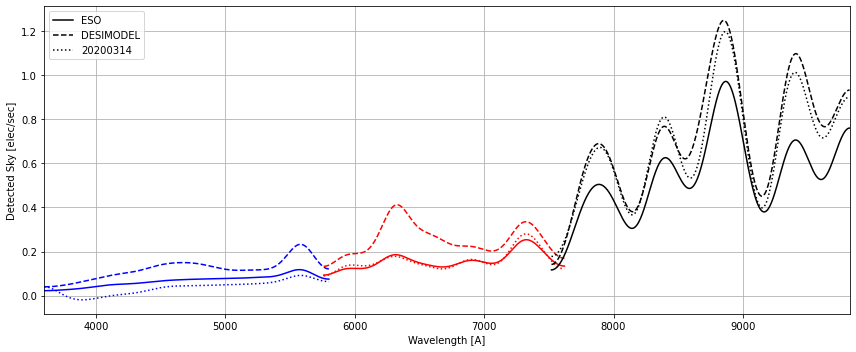

In [17]:
def plot_dark(smoothing=125):#, save='fidsky.png'):
    plt.figure(figsize=(12, 5))
    for camera, color in zip('brz', 'brk'):
        wave = det_darkobs[camera].wave
        plt.plot(wave, scipy.ndimage.gaussian_filter1d(
            det_darkobs[camera].flux, smoothing), ':', c=color, ms=1)
        plt.plot(wave, scipy.ndimage.gaussian_filter1d(
            det_desimodel[camera], smoothing), '--', c=color, ms=1)
        plt.plot(wave, scipy.ndimage.gaussian_filter1d(
            det_eso[camera], smoothing), '-', c=color, ms=1)
    plt.plot([], [], 'k-', label='ESO')
    plt.plot([], [], 'k--', label='DESIMODEL')
    plt.plot([], [], 'k:', label='20200314')
    plt.legend()
    plt.xlabel('Wavelength [A]')
    plt.ylabel('Detected Sky [elec/sec]')
    plt.xlim(fullwave[0], fullwave[-1])
    plt.grid()
    plt.tight_layout()
#    if save:
#        plt.savefig(save)
        
plot_dark()

In [18]:
_depths = {}

In [19]:
def plot_tile_depth(tileid, night, darkref=det_eso, ffracref=0.56, smoothing=125):
    tileid = str(tileid)
    night = str(night)
    fig, ax = plt.subplots(2, 1, figsize=(9, 8))
    # Lookup exposures contributing to the coadd of this (tileid, night).
    expids = exposures_of_tile(tileid, night)
    # Get GFA data for these exposures.
    sel = (gfa_results['tileid'] == int(tileid)) & (gfa_results['night'] == int(night))
    gfa = gfa_results[sel]
    if not np.array_equal(expids, gfa['expid']):
        drop = set(expids) - set(gfa['expid'])
        print(f'WARNING: dropping exposures with no GFA results: {drop}.')
        expids = gfa['expid']
        assert np.all(np.diff(expids) > 0)
    nexp = len(expids)
    exptimes = np.empty((6, nexp))
    exptimes[0] = gfa['exptime']
    exptimes[1] = exptimes[0] * gfa['transparency_med'] ** 2
    exptimes[2] = exptimes[1] * (gfa['fiber_fracflux_med'] / ffracref) ** 2
    # Loop over exposures of this tile.
    for k, expid in enumerate(expids):
        inc, det = get_sky(night, expid)
        for j, camera in enumerate('brz'):
            wave = det[camera].wave
            smoothref = scipy.ndimage.gaussian_filter1d(darkref[camera], smoothing)
            if k == 0:
                ax[1].plot(wave, smoothref, 'k:', label='FIDUCIAL' if camera == 'b' else None)
            smooth = scipy.ndimage.gaussian_filter1d(det[camera].flux, smoothing)
            ax[1].plot(wave, smooth, c=f'C{k}', label=int(expid) if camera == 'b' else None)
            # Calculate the mean ratio of actual / fiducuial sky in each camera.
            #ratio = det[camera] / darkref[camera]
            #mean_ratio = np.sum(ratio.ivar * ratio.flux) / np.sum(ratio.ivar)
            mean_ratio = np.sum(smooth) / np.sum(smoothref)
            #print(k, expid, camera, 'actual/ref =', mean_ratio, mean_ratio2)
            exptimes[3 + j, k] = exptimes[2, k] / mean_ratio
        print(f'{tileid} {night} {expid} b={exptimes[3, k]:6.1f}s r={exptimes[4, k]:6.1f}s  z={exptimes[5, k]:6.1f}s')
    exptimes = np.cumsum(exptimes, axis=1)
    ax[0].plot(exptimes[0], 'c:x', label=f'Actual {exptimes[0, -1]:.0f}s')
    ax[0].plot(exptimes[1], 'c--x', label=f'Transp {exptimes[1, -1]:.0f}s')
    ax[0].plot(exptimes[2], 'c-x', label=f'FFrac {exptimes[2, -1]:.0f}s')
    for j, (camera, color) in enumerate(zip('brz', 'brk')):
        ax[0].plot(exptimes[3 + j], '-o', c=color, label=f'{camera} Sky {exptimes[3 + j, -1]:.0f}s')
    ax[0].set_xlabel('Exposure')
    ax[0].set_xticks([])
    ax[0].set_ylabel('Integrated Exposure Time [s]')
    ax[0].legend()
    ax[0].set_ylim(0, None)
    ax[0].grid()
    ax[1].legend(title=f'{tileid} {night}')
    ax[1].set_xlabel('Wavelength [A]')
    ax[1].set_ylabel('Smoothed Sky Flux [elec/sec]')
    ax[1].grid()
    plt.tight_layout()
#    plt.savefig(f'depth/depth_{tileid}_{night}.png')
    # Save results for a tabular summary.
    _depths[(tileid, night)] = exptimes

67230 20200314 55380 b= 132.4s r= 114.9s  z= 121.0s
67230 20200314 55381 b=  78.8s r=  70.2s  z=  77.3s
67230 20200314 55382 b= 248.6s r= 237.5s  z= 269.1s


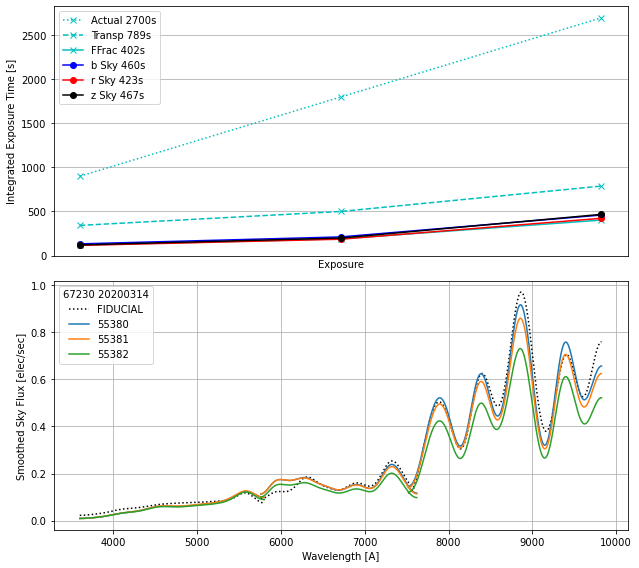

In [20]:
plot_tile_depth(67230, 20200314)

In [21]:
def determine_tile_depth2(tileid, night, expid, darkref=det_eso, ffracref=0.56, smoothing=125):
    tileid = str(tileid)
    night = str(night)
    expid = str(expid)
    # Get GFA data for these exposures.
    sel = (gfa_results['tileid'] == int(tileid)) & (gfa_results['night'] == int(night)) & (gfa_results['expid'] == int(expid))
    gfa = gfa_results[sel]
    exptimes = np.empty((6))
    exptimes[0] = gfa['exptime']
    exptimes[1] = exptimes[0] * gfa['transparency_med'] ** 2
    exptimes[2] = exptimes[1] * (gfa['fiber_fracflux_med'] / ffracref) ** 2
    inc, det = get_sky(night, expid)
    for j, camera in enumerate('brz'):
        wave = det[camera].wave
        smoothref = scipy.ndimage.gaussian_filter1d(darkref[camera], smoothing)
        smooth = scipy.ndimage.gaussian_filter1d(det[camera].flux, smoothing)
        mean_ratio = np.sum(smooth) / np.sum(smoothref)
        exptimes[3 + j] = exptimes[2] / mean_ratio
    _depths[(tileid, night)] = exptimes
    return tileid, night, expid, np.round(exptimes[3],1), np.round(exptimes[4],1), np.round(exptimes[5],1)

In [22]:
#determine_tile_depth2(67230, 20200314, 55380)

In [23]:
bdepth, rdepth,zdepth = [], [], []
for i in range(len(gfa_results)):
#    print(determine_tile_depth2(gfa_results["tileid"][i], gfa_results["night"][i], gfa_results["expid"][i]))
    bdepth.append(determine_tile_depth2(gfa_results["tileid"][i], gfa_results["night"][i], gfa_results["expid"][i])[3])
    rdepth.append(determine_tile_depth2(gfa_results["tileid"][i], gfa_results["night"][i], gfa_results["expid"][i])[4])
    zdepth.append(determine_tile_depth2(gfa_results["tileid"][i], gfa_results["night"][i], gfa_results["expid"][i])[5])

In [24]:
gfa_results=Table(gfa_results)
gfa_results["b_depth"]=bdepth
gfa_results["r_depth"]=rdepth
gfa_results["z_depth"]=zdepth

In [25]:
gfa_results

expid,night,tileid,exptime,mjdobs,tilera,tiledec,airmass_min,airmass_med,airmass_max,moon_sep_deg_min,moon_sep_deg_med,moon_sep_deg_max,transparency_min,transparency_med,transparency_max,fwhm_asec_min,fwhm_asec_med,fwhm_asec_max,sky_mag_ab_min,sky_mag_ab_med,sky_mag_ab_max,fiber_fracflux_min,fiber_fracflux_med,fiber_fracflux_max,ngfa,ebv,b_depth,r_depth,z_depth
int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float64,float64,float64
55380,20200314,67230,900.0,58923.195,138.99736,0.5742274,1.1740034,1.1770529,1.181329,108.45759,108.45767,108.4578,0.37989414,0.6164836,0.7704532,1.34263,1.629009,2.0356383,20.933434,21.077202,21.20532,0.23114638,0.32865107,0.441228,534,0.029372929,132.4,114.9,121.0
55381,20200314,67230,900.0,58923.21,138.99736,0.5742274,1.1715305,1.1716818,1.1722118,108.66422,108.664314,108.66442,0.33697572,0.41902587,0.6497652,1.2470093,1.4677094,1.8849634,20.9655,21.062346,21.249321,0.2520538,0.3759551,0.4796432,534,0.029372929,78.8,70.2,77.3
55382,20200314,67230,900.0,58923.227,138.99736,0.5742274,1.1749086,1.1783749,1.1830773,108.879715,108.8798,108.87989,0.43745524,0.566362,0.69721806,0.9611131,1.2228626,1.737186,21.094257,21.186182,21.352497,0.29964036,0.48135033,0.64808327,534,0.029372929,248.6,237.5,269.1
55395,20200314,68000,900.0,58923.254,214.75,53.4,1.4446021,1.4742445,1.5057209,79.248955,79.24909,79.2492,0.3402091,0.47859454,0.6191475,1.0219626,1.2228626,2.181967,20.599197,20.74585,20.976782,0.20395966,0.4984872,0.6075908,534,0.011782864,147.0,140.2,204.1
55396,20200314,68000,900.0,58923.27,214.75,53.4,1.3664986,1.3913329,1.4176862,79.34726,79.3573,79.35742,0.3157337,0.47813103,0.81062275,1.148491,1.3160685,1.7251127,20.65149,20.853844,21.178482,0.29477322,0.44300145,0.5421777,534,0.011782864,127.7,124.5,183.2
55432,20200314,66014,450.0,58923.36,179.79736,0.5742274,1.1959611,1.1999602,1.2042826,72.456406,72.45651,72.4566,0.16531175,0.2138594,0.34246162,1.0132698,1.1175833,1.3146198,19.073032,19.146255,19.351015,0.41318455,0.5447128,0.6150159,264,0.018267725,3.0,3.6,7.9
55433,20200314,66014,450.0,58923.37,179.79736,0.5742274,1.2135544,1.2188492,1.2244914,72.58849,72.58858,72.58869,0.29612407,0.4222636,0.6301968,0.940347,1.0881244,1.3503568,19.213886,19.37329,19.692513,0.4147269,0.56233704,0.65173006,264,0.018267725,15.1,19.1,40.6
55434,20200314,66014,450.0,58923.38,179.79736,0.5742274,1.2366287,1.2433463,1.2504447,72.72056,72.720634,72.7207,0.122371234,0.19943313,0.82747,0.9379323,1.0707388,1.5449787,18.892847,19.02955,20.06284,0.3339303,0.57869065,0.6798091,264,0.018267725,2.7,3.3,7.3
55435,20200314,66014,450.0,58923.39,179.79736,0.5742274,1.2650166,1.2732774,1.2819602,72.85255,72.85264,72.85271,0.120953865,0.1584904,0.23376183,0.9408299,1.0890902,1.298683,18.819672,18.934246,19.151428,0.4524245,0.5633441,0.7234285,264,0.018267725,1.4,1.6,3.6


In [26]:
gfa_results.write("desi_sv0_exposures_gfa_with_depth.fits",overwrite=True)

In [27]:
gfa_results_new=Table(fitsio.read("desi_sv0_exposures_gfa_with_depth.fits"))

In [28]:
gfa_results_new

expid,night,tileid,exptime,mjdobs,tilera,tiledec,airmass_min,airmass_med,airmass_max,moon_sep_deg_min,moon_sep_deg_med,moon_sep_deg_max,transparency_min,transparency_med,transparency_max,fwhm_asec_min,fwhm_asec_med,fwhm_asec_max,sky_mag_ab_min,sky_mag_ab_med,sky_mag_ab_max,fiber_fracflux_min,fiber_fracflux_med,fiber_fracflux_max,ngfa,ebv,b_depth,r_depth,z_depth
int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float64,float64,float64
55380,20200314,67230,900.0,58923.195,138.99736,0.5742274,1.1740034,1.1770529,1.181329,108.45759,108.45767,108.4578,0.37989414,0.6164836,0.7704532,1.34263,1.629009,2.0356383,20.933434,21.077202,21.20532,0.23114638,0.32865107,0.441228,534,0.029372929,132.4,114.9,121.0
55381,20200314,67230,900.0,58923.21,138.99736,0.5742274,1.1715305,1.1716818,1.1722118,108.66422,108.664314,108.66442,0.33697572,0.41902587,0.6497652,1.2470093,1.4677094,1.8849634,20.9655,21.062346,21.249321,0.2520538,0.3759551,0.4796432,534,0.029372929,78.8,70.2,77.3
55382,20200314,67230,900.0,58923.227,138.99736,0.5742274,1.1749086,1.1783749,1.1830773,108.879715,108.8798,108.87989,0.43745524,0.566362,0.69721806,0.9611131,1.2228626,1.737186,21.094257,21.186182,21.352497,0.29964036,0.48135033,0.64808327,534,0.029372929,248.6,237.5,269.1
55395,20200314,68000,900.0,58923.254,214.75,53.4,1.4446021,1.4742445,1.5057209,79.248955,79.24909,79.2492,0.3402091,0.47859454,0.6191475,1.0219626,1.2228626,2.181967,20.599197,20.74585,20.976782,0.20395966,0.4984872,0.6075908,534,0.011782864,147.0,140.2,204.1
55396,20200314,68000,900.0,58923.27,214.75,53.4,1.3664986,1.3913329,1.4176862,79.34726,79.3573,79.35742,0.3157337,0.47813103,0.81062275,1.148491,1.3160685,1.7251127,20.65149,20.853844,21.178482,0.29477322,0.44300145,0.5421777,534,0.011782864,127.7,124.5,183.2
55432,20200314,66014,450.0,58923.36,179.79736,0.5742274,1.1959611,1.1999602,1.2042826,72.456406,72.45651,72.4566,0.16531175,0.2138594,0.34246162,1.0132698,1.1175833,1.3146198,19.073032,19.146255,19.351015,0.41318455,0.5447128,0.6150159,264,0.018267725,3.0,3.6,7.9
55433,20200314,66014,450.0,58923.37,179.79736,0.5742274,1.2135544,1.2188492,1.2244914,72.58849,72.58858,72.58869,0.29612407,0.4222636,0.6301968,0.940347,1.0881244,1.3503568,19.213886,19.37329,19.692513,0.4147269,0.56233704,0.65173006,264,0.018267725,15.1,19.1,40.6
55434,20200314,66014,450.0,58923.38,179.79736,0.5742274,1.2366287,1.2433463,1.2504447,72.72056,72.720634,72.7207,0.122371234,0.19943313,0.82747,0.9379323,1.0707388,1.5449787,18.892847,19.02955,20.06284,0.3339303,0.57869065,0.6798091,264,0.018267725,2.7,3.3,7.3
55435,20200314,66014,450.0,58923.39,179.79736,0.5742274,1.2650166,1.2732774,1.2819602,72.85255,72.85264,72.85271,0.120953865,0.1584904,0.23376183,0.9408299,1.0890902,1.298683,18.819672,18.934246,19.151428,0.4524245,0.5633441,0.7234285,264,0.018267725,1.4,1.6,3.6
